In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# inspect database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# get a list of column names and types for measurements table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
max_date = session.query(func.min(Measurement.date)).all()[0][0]
results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
      filter(Measurement.date < "2017-08-24").\
      filter(Measurement.date > "2016-08-23").\
        order_by(Measurement.date).\
        group_by(Measurement.date).\
        all()
df = pd.DataFrame(results, columns = ["date", "precipitation"])
df.head()

,date,precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


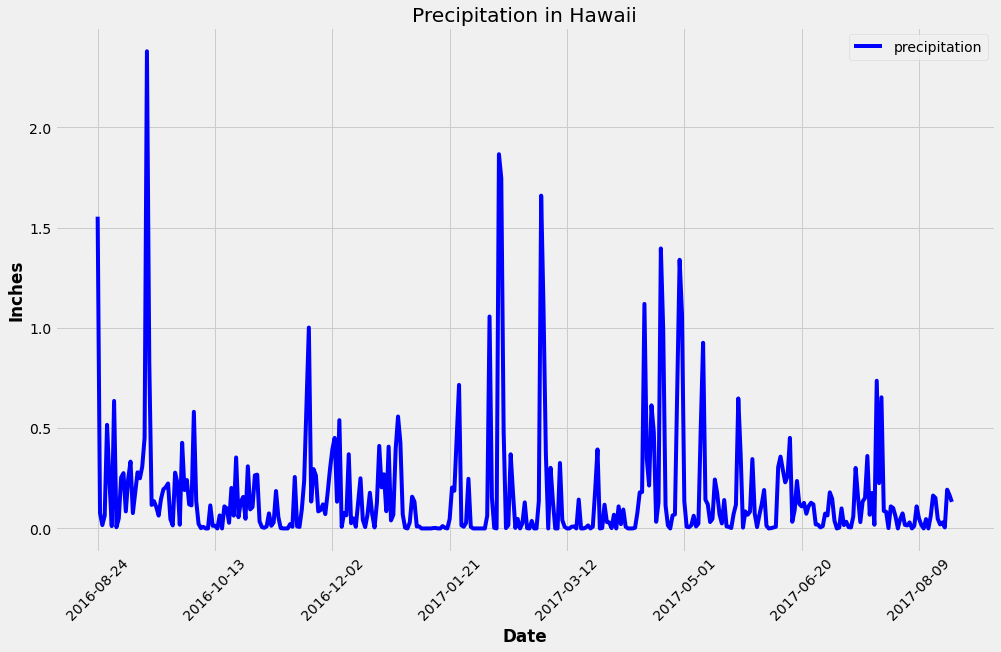

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(rain_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date
df = df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
rain_chart = df.plot(figsize = (15, 9), sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='b')
plt.ylabel('Inches', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii")
plt.savefig("output/precip.png")
plt.show()




In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(Station)
print("There are {} stations.".format(locations.count()))

There are 9 stations.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations_descending = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station_name = ""
most_active_station = active_stations_descending[0][0]

for location in locations:
    if(location.station == active_stations_descending[0][0]):
        most_active_station_name = location.name 
print(f"The most active stations information is as follows: ")
print(f" Name    : {most_active_station_name} ")
print(f" Station : {active_stations_descending[0][0]}")
print(f" Count   : {active_stations_descending[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")
for active_station_descending in active_stations_descending:
    print(active_station_descending[0], "   ", active_station_descending[1])

The most active stations information is as follows: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_frequencies = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"The Lowest, Highest & the average temperature for most active station {most_active_station} is :")
print(f" Low  : {temperature_frequencies[0][0]}")
print(f" High : {temperature_frequencies[0][1]}")
print(f" Avg  : {temperature_frequencies[0][2]}")

The Lowest, Highest & the average temperature for most active station USC00519281 is :
 Low  : 54.0
 High : 85.0
 Avg  : 71.66378066378067


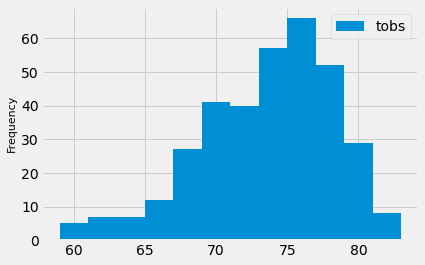

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

#Plot the results as a histogram with bins=12
plt.hist(temp_results_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.savefig("Output/Temperature_for_active station_last_12months.png")
plt.show()

# Close session

In [17]:
# Close Session
session.close()